# RL coursework, part IV (30 pts in total)

---

**Name:** Ana Kapros

**SN:** 19018725

---

**Due date:** *27 March, 2023*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part4.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

### Objectives

#### Q.1: You will implement a number of off-policy multi-step return estimates, and answer questions about their accuracy.

#### Q.2: You will be looking at other, TD-like, updates to learn the value function. You will be asked to investigate different properties of these: e.g. convergence properties, variance of updates. This is akin to a typical analysis one would undertaken when proposing a new update rule to learn value functions.


## Imports

In [42]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

## Q1 [11 points total]
For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necessary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency. 

In [43]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  del pi
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
    
  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

### Q 1.1 [5 points]
Implement the return functions below and run the cells below that.

In [44]:
def importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn, correction_type):
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  rho = 1

  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    # The importance sampling correction for timestep t is 
    # \rho_t = \frac{\pi(A_t|S_t)}{\mu(A_t|S_t)}
    rho_t = pi[t] / mu[t]
    # rho = rho_{t:T-1} = \Pi_{k=t}^{T-1}\rho_k i.e. the correction for 
    # trajectory from step t until the end
    rho *= rho_t
    if correction_type == 'full_importance_sampling':
      # full importance sampling applies the correction rho=\rho_{t:T-1} to G_t
      if t == T - 1:
        G[t] = rho * (r[t] + d[t]*v[t + 1])
      else:
        G[t] = rho * r[t] + d[t]*(rho * (1 - l)*v[t + 1] + rho_t * l*G[t + 1])
    else:
      assert (correction_type == 'per_decision'), f'Importance sampling using {correction_type} not implemented!'
      if t == T - 1:
        G[t] = rho_t * (r[t] + d[t]*v[t + 1])
        assert (d[t] == 0)
      else:
        G[t] = rho_t * (r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1]))
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def importance_sampling_errors_recursion(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn, correction_type):
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
    
  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    rho_t = pi[t] / mu[t]
    if correction_type == 'control_variates':
      error = rho_t * (r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error)
      # control variates is adaptive bootstrapping with lambda_t = 1, \forall t
    else:
      assert (correction_type == 'adaptive_bootstrapping'), f'Importance sampling using {correction_type} not implemented!'
      lambda_t = l * min(1, 1/rho_t)
      error = lambda_t * rho_t * (r[t] + d[t]*v[t + 1] - v[t] + d[t]*error)
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors


def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with full importance-sampling corrections, so that
  the return G_t is corrected with the full importance-sampling correction of
  the rest of the trajectory.
  """
  return importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, 
                             v_fn, correction_type='full_importance_sampling')

def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with per-decision importance-sampling corrections.
  """
  return importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, 
                             v_fn, correction_type='per_decision')

def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with 
  1. per-decision importance-sampling corrections, and
  2. control variates
  """
  return importance_sampling_errors_recursion(observations, actions, pi, mu, rewards, discounts, trace_parameter, 
                             v_fn, correction_type='control_variates')

def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with 
  1. per-decision importance-sampling corrections, and
  2. control variates, and
  3. adaptive bootstrapping.

  Implement the adaptive bootstrapping with an *additional* trace parameter
  lambda, such that lambda_t = lambda * min(1, 1/rho_t).
  """
  return importance_sampling_errors_recursion(observations, actions, pi, mu, rewards, discounts, trace_parameter, 
                             v_fn, correction_type='adaptive_bootstrapping')

In [45]:
#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...
  
  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=np.int)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state

  # in this case, observations are just the real states
  observations = states

  # generate rewards
  rewards     = 2.*actions - 1. # -1 for left, +1 for right, 
  rewards[-1] = np.sum(actions)  # extra final reward for going right
    
  # compute discounts
  discounts     = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0

  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities
    
  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2)
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1)
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward



C:\Users\Ana\AppData\Local\Temp/ipykernel_8144/3359063109.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


[ 19.524 594.355 186.319   6.407   0.706]


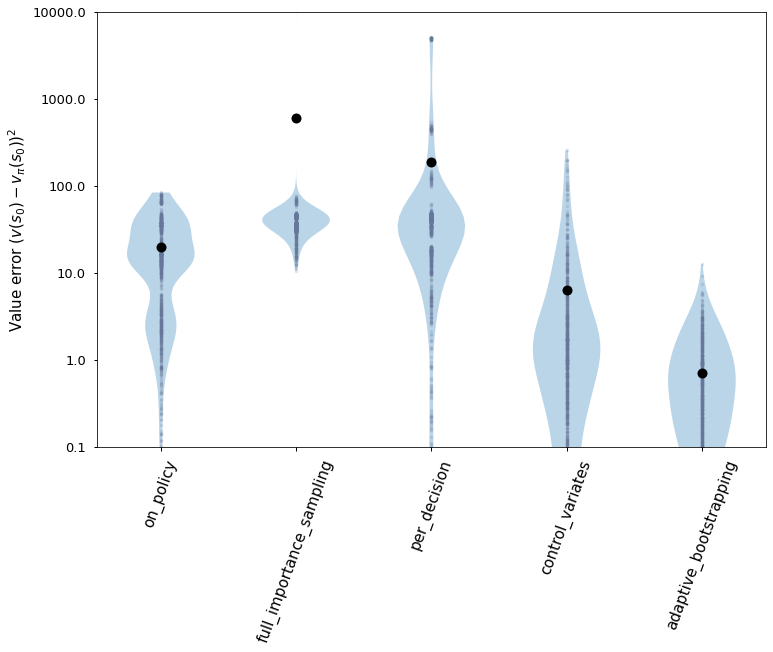

In [47]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision', 'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise 

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    estimates[-1].append(estimate[0])
    errors[-1].append((estimate[0] - v0)**2)
print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

In [57]:
print(f'The variance for each algorithm is {np.std(estimates, axis=0) ** 2}')
print(f'The mean for each algorithm is {np.mean(estimates, axis=0)} compared to true value = {v0}')

The variance for each algorithm is [  5.328 594.337 186.276   6.406   0.674]
The mean for each algorithm is [3.707 7.34  7.683 7.461 7.297] compared to true value = 7.475001245000001


Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 1.2 [3 points]
Explain the ranking in terms of value error of the different return estimates.

> The behaviour policy is uniformly random, while the target is to go right 90% of the time, with the optimal policy being to always choose the right action (as the reward for right is 1 and for choosing left is -1 regardless of states). The significant difference between the target and behaviour policy explains why the algorithms that correct for being off-policy while also controlling variance s.a. control variates and adaptive bootstrapping have a lower MSE that the on-policy algorithm. The variance of errors is also lower for control variates and adaptive bootstrapping than for the per-decision and full importance sampling, as the correction is added to the TD error rather than the return. As expected, the full importance sampling has very high variance due to applying corrections at every time step in the form of $G_t^{\rho} = \rho_{t:T-1} \sum_{k=t}^{T-1} \gamma^{k-t} R_{k+1}$, even if they are not needed. The variance is significantly reduced by applying corrections "per decision": $G_t^{\rho} = \sum_{k=t}^{T-1} \gamma^{k-t} \rho_{t:k} R_{k+1}$. Control variates have a slightly higher variance than the on-policy model, but the mean error is lower for the latter, and adaptive bootstrapping performs better both in terms of value estimation accuracy and variance, as it tailors the amount of bootstrapping according to how off-policy is the selected action. By looking at the mean of estimates, we observe that all off-policy models are significantly closer than the algorithm that doesn't add corrections, but the high variance for the full and per-decision importance sampling results in a higher MSE. Finally, even if the mean estimate for control variates is closer to the true value than for adaptive bootstrapping, the lower variance for the latter decreases its MSE.




### Q 1.3 [3 points]
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

> Adaptive bootstrapping is by far the best-performing model, with the bootstrapping parameter $\lambda_t = \lambda min(1, \frac{1}{\rho_t})$. If the action selected is less likely in the target policy than in the behaviour policy, i.e. $\pi(a|s) < \mu(a|s)$, then $\rho_t \le 1$, and $\lambda_t = \lambda$. Otherwise, $\lambda_t = \lambda \frac{\mu(a|s)}{\pi(a|s)}$, and the more off-policy we are, the more we bootstrap (i.e. $\lambda_t$ is lower because $\frac{\pi(a|s)}{\mu(a|s)}$ is larger).\
In settings where the value estimates are biased, bootstrapping too much will increase the bias even further, while using control variates will allow using fixed bootstrapping, at the expense of potentially higher variance. In the given setting, the control variates mean ($7.461$) is closer to the true value ($7.475$) as compared to adaptive bootstrapping ($7.297$), but the latter has a significantly lower variance ($0.674$ compared to $6.406$), and hence a smaller MSE. Finally, bootstrapping too much in the off-policy case can lead to divergence of the value function in the function approximation setting, due to entering the `deadly triad`.

## Q2 [19 points total]
 Consider a MDP $M = (\mathcal{S}, \mathcal{A}, p, r, \gamma)$ and a behaviour policy $\mu$. We use policy $\mu$ to generate trajectories of experience:
\begin{equation*}
    (s_{t}, a_{t}, r_{t},s_{t+1}, a_{t+1}, r_{t+1},\cdots, s_{t+n-1}, a_{t+n-1}, r_{t+n-1}, s_{t+n}, a_{t+n}) \,.
\end{equation*}
Note that this is an $n$-step sequence, starting from time $t$.

Given these partial trajectories we consider the following learning problems:




### Q2.1 [9 points]
Consider a learning update based on the following temporal difference error:
$$\delta_t = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t)$$

Consider updating a tabular action value function with TD.

i) Does the resulting value function converge, under any initialisation of the value function? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove the convergence under infinity number of interactions with this MDP, under fixed behaviour policy $\mu$ and show its convergence point. If not, show why it diverges. (7 points)

ii) Under which conditions, would the above process converge to the optimal value function $q_*$ ? (2 points)

* i). 

Considering the true MDP dynamics are modelled by $P(s'|s, a), R(s'|s, a)$ (i.e. the transition dynamics and reward function):
<!-- and $P(s'|s, a), R(s'|s, a)$ are the dynamics after interacting infinitely with the environment using behaviour policy $\mu$, we get -->
$E_{\mu, P, R}[R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) | S_t, A_t] = \sum_{S_{t+1}} P(S_{t+1}|S_t, A_t) (R(S_{t+1}|S_{t}, A_{t}) + \gamma \sum_{A_{t+1}} \mu(A_{t+1}|S_{t+1}) \sum_{S_{t+2}} P(S_{t+2}|S_{t+1}, A_{t+1}) (R(S_{t+2}|S_{t+1}, A_{t+1}) + \gamma max_{a} q(S_{t+2}, a))) = A^{\mu} q(S_t, A_t)$.

Here, we defined $A^{\mu}$ to be the operator associated with updating the state-action value function using two steps as above. 

The expectation equality shows the equivalence between infinitely performing the TD update and applying $A^{\mu}$ to the state-action value function. 
<!-- However, for the operator to use the true MDP dynamics, the behaviour policy must ensure infinite exploration.  -->

We will prove that the operator is a $\gamma^2$ contraction:

$A^{\mu} q_1(S_t, A_t) - A^{\mu} q_2(S_t, A_t) = 
\sum_{S_{t+1}} P(S_{t+1}|S_t, A_t) \gamma \sum_{A_{t+1}} \mu(A_{t+1}|S_{t+1}) \sum_{S_{t+2}} P(S_{t+2}|S_{t+1}, A_{t+1}) (\gamma (max_{a} q_1(S_{t+2}, a) - max_b q_2(S_{t+2}, b)))$ because the MDP dynamics and policy are the same, and the rest of the terms cancel out.

$max_{a} q_1(S_{t+2}, a) - max_b q_2(S_{t+2}, b) \le max_{a} (q_1(S_{t+2}, a) - q_2(S_{t+2}, a)) \le max_{s} max_{a}  (q_1(s, a) - q_2(s, a)) \le ||q_1 - q_2||$

Thus, $|| A^{\mu} q_1(S_t, A_t) - A^{\mu} q_2(S_t, A_t)|| \le \gamma^2 \sum_{S_{t+1}} P(S_{t+1}|S_t, A_t) \sum_{A_{t+1}} \mu(A_{t+1}|S_{t+1}) \sum_{S_{t+2}} P(S_{t+2}|S_{t+1}, A_{t+1}) ||q_1 - q_2||$, and in expectation:

$||A^{\mu} q_1 - A^{\mu} q_2|| \le \gamma^2 ||q_1 - q_2||$

Hence, the operator is a $\gamma^2$ contraction and, by Banach's Fixed Point Theorem, the operator has a unique fixed point $q^{\mu}$ s.t. $A^{\mu}q^{\mu} = q^{\mu}$. Because $\gamma < 1$, applying the operator $n$ times, as $n\to\infty$ will converge in a geometric fashion.

Assuming $q_0$ as the initial q-value function, we have
$\lim_{n\to\infty} ||q_n - q^{\mu}|| \le \lim_{n\to\infty} ||(A^{\mu})^{n}q_0 - (A^{\mu})^{n}q^{\mu}|| \le \lim_{n\to\infty} \gamma^{2n} ||q_0 - q^{\mu}|| = 0$

Note that $q^{\mu}$ depends on the behaviour policy, and if $\mu$ is not GLIE, as shown in the second part, $q^{\mu} \ne q^*$. 
<!-- This can easily be seen for an example with 5 states. TODO: write example-->

* ii).

The above algorithm will converge to $q^*$ if the policy is GLIE. The infinite exploration is required s.t. all states are visited infinitely often and the expectation becomes unbiased in the limit, while the greedy in the limit ensures that the updates will approximate the Bellman optimality operator, and the updates are on-policy in the limit.

For $\pi$ greedy in the limit: \
$E_{\pi, P, R}[R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) | S_t, A_t] = \sum_{S_{t+1}} P(S_{t+1}|S_t, A_t) (R(S_{t+1}|S_{t}, A_{t}) + \gamma max_{a'} \sum_{S_{t+2}} P(S_{t+2}|S_{t+1}, a') (R(S_{t+2}|S_{t+1}, a') + \gamma max_{a''} q(S_{t+2}, a''))) = \sum_{S_{t+1}} P(S_{t+1}|S_t, A_t) (R(S_{t+1}|S_{t}, A_{t}) + \gamma max_{a'} T^* q(S_{t+1}, a')) = T^* (T^*(S_{t}, A_t))$

<!-- $$E[\delta_t] = E[R(S_t, A_t) + \gamma (R(S_{t+1}, A_{t+1}) + \gamma \max_a q(S_{t+2}, a))]$$ -->

<!-- $E[R(S_{t+1}, A_{t+1}) + \gamma \max_a q(S_{t+2}, a) | S_{t}, A_{t}] = E[\sum_{s'} P(s'|S_t, A_t) \sum_{a'} \mu(a'|s') R(s', a') + \gamma  \max_a q(S_{t+2}, a) | S_{t+1}, A_{t+1}]$

If the behaviour policy $\mu$ is $\epsilon$-greedy, such that state-action pairs are explored infinitely often, but the policy is greedy in the limit,  -->

Then $E[R(S_{t+1}, A_{t+1}) + \gamma \max_a q(S_{t+2}, a) | S_{t}, A_{t}] = \sum_{s'} P(s'|S_t, A_t) \max_{a'} E[q(s', a')]$ and

$E[\delta_t] = R(S_t, A_t) + \gamma \sum_{s'} P(s'|S_t, A_t) \max_{a'} q(s', a') - q(S_t, A_t)$. 

In the limit, using the TD error with GLIE behaviour policy gives the Bellman Optimality operator. Hence, because policy iteration with the Bellman Optimality operator converges to the optimal value function, the process using GLIE $\pi$ will converge to $q^*$.

### Q2.2 [10 points]

Consider the same questions now for the following temporal difference error
\begin{equation}
        \delta_t = r(S_{t},A_{t}) + \gamma \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} \left[ r(S_{t+1},A_{t+1}) + \gamma \max_a q(S_{t+2},a) \right] - q(S_t, A_t)
\end{equation}

where $\pi(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$ and consider the behaviour policy to be either:

  a. $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$,
  
  b. $\mu(a|s) = \frac{1}{|\mathcal{A}|}$ (uniformly random policy).

Answer the below two questions for **both choices** of the behaviour policy $\mu$:
* i)  Does updating a tabular action value function with this TD error converge to the optimal value function $q_*$? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove this convergence under infinity number of interaction with this MDP, under behaviour policy $\mu$. If not, show why it diverges or alternatively convergence to a different solution. (4 points)
* ii) How does the variance of this update compare to the one induced by the error in Q5.1? (3 points). 
* iii) Can you propose a different behaviour policy that achieves a lower variance than any of the choices we considered for $\mu$? Prove that your behaviour policy achieve this. Argue why, if that is not possible. (3 points)

#### a.
> i). \
For $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$, the update becomes
$\delta_t = r(S_{t},A_{t}) + \gamma \frac{\pi(A_{t+1}|S_{t+1})}{\pi(A_{t+1}|S_{t+1})} \left[ r(S_{t+1},A_{t+1}) + \gamma \max_a q(S_{t+2},a) \right] - q(S_t, A_t) = r(S_{t},A_{t}) + \gamma  r(S_{t+1},A_{t+1}) + \gamma^2 \max_a q(S_{t+2},a)- q(S_t, A_t) $. \
The update is equivalent to the one at question $Q2.1$ considering the greedy behaviour policy, and we have shown that the update converges regardless of the behaviour policy. Alternatively, because the TD updates for the tabular case always converge, we know the algorithm following this update will converge. \
Because the behaviour policy is greedy, we will not explore all states often enough, and hence, the solution will not converge to the optimal value function: in the tabular case, if we don't visit a state-action pair $(s, a)$ often enough, we can't expect to have generalisation s.t. in the limit, $q(s, a) \approx q^*(s, a)$.

> ii). \
Because the target and behaviour policies are the same, the correction is $\frac{\pi(A_{t+1}|S_{t+1})}{\pi(A_{t+1}|S_{t+1})} = 1$, and there is no difference to the error in the previous question. Thus, the variance does not change.

#### b.
> i). \
$E_{\mu, P, R}[r(S_t, A_t) + \gamma \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} \left [ r(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) \right ] | S_t, A_t] = \sum_{S_{t+1}} P(S_{t+1}|S_t, A_t) (R(S_{t+1}|S_{t}, A_{t}) + \gamma \sum_{A_{t+1}} \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} \mu(A_{t+1}|S_{t+1}) \sum_{S_{t+2}} P(S_{t+2}|S_{t+1}, A_{t+1}) (R(S_{t+2}|S_{t+1}, A_{t+1}) + \gamma max_{a} q(S_{t+2}, a))) = \sum_{S_{t+1}} P(S_{t+1}|S_t, A_t) (R(S_{t+1}|S_{t}, A_{t}) + \gamma \sum_{A_{t+1}} \pi(A_{t+1}|S_{t+1}) \sum_{S_{t+2}} P(S_{t+2}|S_{t+1}, A_{t+1}) (R(S_{t+2}|S_{t+1}, A_{t+1}) + \gamma max_{a} q(S_{t+2}, a))) = \sum_{S_{t+1}} P(S_{t+1}|S_t, A_t) (R(S_{t+1}|S_{t}, A_{t}) + \gamma \left [ max_{a'} q(S_{t+1}, a') \sum_{S_{t+2}} P(S_{t+2}|S_{t+1}, A_{t+1}) (R(S_{t+2}|S_{t+1}, A_{t+1}) + \gamma max_{a} q(S_{t+2}, a)) \right]$ \
Thus, the importance sampling correction ensures the expected value of the update is equal to the expected value of the greedy TD update. \
Because the behaviour policy will visit all states infinitely often, the infinite exploration condition is satisfied, while the importance sampling correction ensures that the expected update, in the limit, is equal to the Bellman optimality update. Given these two properties, the TD update with uniformly random behaviour policy converges to the optimal value function $q^*$.

> ii). The importance sampling correction increases the variance of the update, and it can be proven as below, denoting $\delta_t^{\mu}, \tilde{\delta_{t}^{\mu}}$ as the TD update in Q2.1 and Q2.2 respectively. \
$Var[\delta_t^{\mu}] = E[(\delta_t^{\mu})^2] - E[\delta_t^{\mu}]^2$ \
$Var[\tilde{\delta_t^{\mu}}] = E[\tilde{(\delta_t^{\mu})}^2] - E[\tilde{\delta_t^{\mu}}]^2$ \
We first show $E[(\delta_t^{\mu})^2] < E[\tilde{(\delta_t^{\mu})}^2]$. \
$E[\tilde{(\delta_t^{\mu})}^2] - E[(\delta_t^{\mu})^2] = E[(\tilde{(\delta_t^{\mu})} - \delta_t^{\mu})(\tilde{(\delta_t^{\mu})} + \delta_t^{\mu})] \Rightarrow$ \
$E[\tilde{(\delta_t^{\mu})}^2] - E[(\delta_t^{\mu})^2] = E[\left[ r(S_{t+1},A_{t+1}) + \gamma \max_a q(S_{t+2},a) \right] * (\frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})}-1) [\left[ r(S_{t+1},A_{t+1}) + \gamma \max_a q(S_{t+2},a) \right] * (\frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})}+1) + 2 (r(S_t, A_t) - q(S_t, A_t))])$ 

> iii). The lowest variance is achieved for the greedy policy, as no importance sampling is performed. 
In part i), we have shown that for any behaviour policy, the expected value of the update is the same, due to the importance sampling correction. Hence, using $Var[X] = E[X^2] - E[X]$ and knowing that the expected value is the same regardless of policy, the policy with the lowest variance minimises the first term. 